Name: Ibrahim Odumas Odufowora <br />
Course: Machine Learning <br />
Project Name: Classification with MNIST <br />

If the Latex formula are not showing correctly, please use chrome browser.

# Problems Identification:
This project involves the implementation of efficient and effective Naive Bayes and Logistic Regression classifiers on MNIST data set. The MNIST data comprises of digital images of several digits ranging from 0 to 9. Each image is 28 x 28 pixels. Thus, the data set has 10 levels of classes.

These are the needed packages:

In [47]:
import warnings
from scipy.stats import mode
import numpy as np
from mnist import MNIST
from time import time
import pandas as pd
import os
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)
import random
plt.rcdefaults()
from IPython.display import display, HTML
from itertools import chain
from sklearn.metrics import confusion_matrix
from pylab import subplot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import pandas as pd
import numpy as np
from plotly.graph_objs import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')

Load the dataset, having downloaded it from Yann. The train data set comprises of 60,000 samples and the test data set has 10,000 samples.

In [9]:
__mndata__ = MNIST(os.getcwd() +'\\image')
__train_image__, __train_label__ = __mndata__.load_training() #train & train_label
__test_image__, __test_label__ = __mndata__.load_testing() #test & test_label

The train and test images were reshaped to 784 dimension long, which translate to one feature for each pixel in the image.

### Visualization:
Visualizing a random 28 by 28 image.

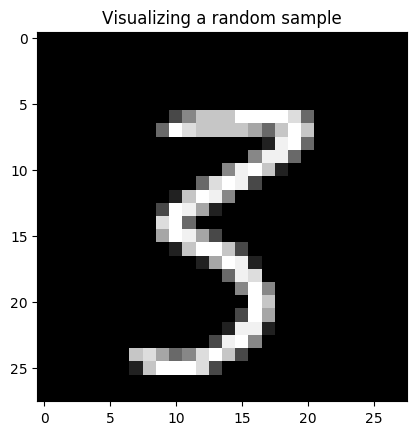

In [147]:
plt.imshow(np.reshape(train[random.randint(1,1000)], [28,28]), cmap='Greys_r'); plt.title('Visualizing a random sample'); plt.show()

### Implementation functions:

In [43]:
class Utility:
    """This class warehouses the data and other general functions"""
    def __init__(self):
        self.train = np.asarray([np.reshape(x, (784)) for x in __train_image__]).astype('float64') #change train_image to numpy array #784 means 28 by 28 pixel
        self.train_label = np.asarray(__train_label__)
        self.test = np.asarray([np.reshape(x, (784)) for x in __test_image__]).astype('float64') #change test_image to numpy array
        self.test_label = np.asarray(__test_label__)
        self.n_class = list(range(10)) #class labels
        
    def confusionMatrix(self, actual, predict, print_cfm=True, print_err_digit=True):
        cfm = pd.DataFrame(confusion_matrix(actual, predict))
        err_all = round((1 - sum(np.diagonal(cfm)) / len(predict)) * 100, 4)
        error_digit = []
        for i in self.n_class:
            error_digit.append(round(1 - cfm.iloc[i,i] / sum(cfm.iloc[i,:]), 4) * 100)

        tab_error = pd.DataFrame(columns=['digit', 'error per digit in %'])
        tab_error['digit'] = self.n_class
        tab_error['error per digit in %'] = error_digit

        if print_cfm:
            print('Testing Confusion Matrix: Actual vs. Prediction')
            display(cfm)

        if print_err_digit:
            print('% error per digit')
            display(tab_error)
            print('\nThe overall testing error is {}%'.format(err_all))

        return cfm, tab_error, err_all


    def nFoldCV_NB(self, train, train_label, smoothings, kFolds):
        stra_all = self.folds_stratify(nSample=len(train), kFolds=kFolds)
        ave_test_err = []
        for s, sVal in enumerate(smoothings):
            test_err = []
            for k in range(kFolds):
                stra = stra_all.copy()
                te = train[stra[k]]
                te_lb = train_label[stra[k]]
                del stra[k]  # del test list
                tr = train[list(chain.from_iterable(stra))]
                tr_lb = train_label[list(chain.from_iterable(stra))]
                nb = NaiveBayes(train=tr, train_lb=tr_lb, test=te, test_lb=te_lb, smoothing=sVal)
                nb.predict()
                conf = self.confusionMatrix(te_lb, nb.pred, False, False)
                test_err.append(conf[2])

            ave_test_err.append(np.mean(test_err))

        return ave_test_err

    def folds_stratify(self, nSample, kFolds):
        """This return kfold stratification"""
        foldSize = round(nSample / kFolds, 0)
        randomList = list(range(0, nSample))
        random.shuffle(randomList)
        stratify = []

        for k in range(0, kFolds):
            strt = int(k * foldSize)
            end = int((k + 1) * foldSize)
            if k == (kFolds - 1):
                end = nSample
            stratify.append(list(randomList)[strt:end])

        return stratify
    
    def CV_plot(k_error, k_list, title):
        k_error = np.round(k_error, 4)
        best_k = k_list[np.argmin(k_error)]
        err_best_k = np.min(k_error)
        plt.plot(k_list, k_error, '-gD', color='black')
        ax = subplot(111)
        ax.set_xticks(k_list, k_list)
        plt.ylabel('% Error')
        plt.xlabel(title)
        plt.title('Plot of ' + title + ' vs. average 5 foldCV error')
        plt.show()
        print('The best value of ' + title + ' is {} with an error of {}%'.format(best_k, err_best_k))
        print('\n' + title + ' = {} will be used to model the entire training set and prediction on testing set:'.format(best_k))
        return best_k, err_best_k
        
    def images_plot(imageData):
        classes = ["P(x|c=0)", "P(x|c=1)", "P(x|c=2)", "P(x|c=3)", "P(x|c=4)", "P(x|c=5)", "P(x|c=6)", "P(x|c=7)",
                   "P(x|c=8)", "P(x|c=9)"]

        num_classes = len(classes)
        plt.subplots(figsize=(15, 2))
        for y, cls in enumerate(classes):
            plt_idx = y + 1
            plt.subplot(1, num_classes, plt_idx)
            if prob:
                plt.imshow(imageData[y].reshape((28, 28)))
            else:
                plt.imshow(imageData[y].reshape(785, 1)[1:785].reshape((28, 28)))
            plt.axis("off")
            plt.title(cls)

        plt.tight_layout()
        plt.show()
        
#End of Class Utility

class NaiveBayes:
    """This class warehouses the Naive bayes classifier"""
    def __init__(self, train, train_lb, test, test_lb, smoothing, jupyter=True, plot_dis=False):
        self.n_class = np.unique(train_lb)
        self.tr = train
        self.te = test
        self.tr_lb = train_lb
        self.te_lb = test_lb
        self.plot_dis = plot_dis
        self.jupyter = jupyter
        self.smoothing = smoothing
        if jupyter:
            self.plotly = iplot
        else:
            self.plotly = plot

    def mean_std_prior(self):
        """Mean and Std per feature per class, and prior per class"""
        self.mean, self.std, self.priors, self.count = [], [], [], []
        for i, val in enumerate(self.n_class):
            sep = [self.tr_lb == val] #separated
            self.count.append(len(self.tr_lb[sep]))
            self.priors.append(len(self.tr_lb[sep]) / len(self.tr_lb))
            self.mean.append(np.mean(self.tr[sep], axis=0))
            self.std.append(np.std(self.tr[sep], axis=0))

        if self.plot_dis:
            bar_data = Bar(x=list(range(len(self.count))), y=self.count)
            data_plt = Data([bar_data])
            layout = Layout(yaxis=YAxis(title='counts'), xaxis=XAxis(title='classes', dtick=1),
                            title='Class distribution in Train set')
            fig = Figure(data=data_plt, layout=layout)
            self.plotly(fig)

    def predict(self):
        """prediction: by summing the natural log of all the conditional probability given the class."""
        str_time = time()
        self.mean_std_prior()
        self.pred = []
        self.likelihood = []
        self.logsum_chk = []
        for n in range(len(self.te_lb)):
            classifier = []
            sample = self.te[n] #test sample
            likelih = []
            for i, val in enumerate(self.n_class):
                mean = self.mean[i]
                var = np.square(self.std[i]) + self.smoothing
                prob = 1 / np.sqrt(2 * np.pi * var) * np.exp(-np.square(sample - mean)/(2 * var))
                result = np.sum(np.log(prob)) #, np.log(self.priors[i])) #not needed, we assume equal prior
                classifier.append(result)
                likelih.append(prob)

            self.pred.append(np.argmax(classifier))
            self.likelihood.append(likelih)
            self.logsum_chk.append(classifier)

        self.end_time = time() - str_time

#End of Class Naive Bayes

# Question 1: 
I implemented a Naive Bayes classifier and presented the testing error for each digit in a table. 

Below are the implemention explanations:

Assuming that the probability model for each pixel is Gaussian and that the probability of each class — i.e., digit—is equal. That is, P(c = 0) = P(c = 1) = : : : = P(c = 9), thus, there is no need to model the prior probabilities.

$$P(c \ | \ X) \approx \prod_{i=1}^{784}P(x_{i} \ | \ c)$$

In order to manage underflow error, the function below will be modeled:

$$ ln \ P(c \ | \ X) \approx \sum_{i=1}^{784} ln \ P(x_{i} \ | \ c) $$

$$ where \ P(x_{i}|c) = N(\mu_{i},\sigma_{i}^{2}\ | \ c) \    is \ modeled \ as \ a \ Gaussian \ from \ the \ training \ data. $$

$$ Thus, \ \mu_{i}|c \ and \ \sigma_{i}^{2}|c  \ were \ determined \ using \ the \ training \ set.$$


In order to avoid zero variance while computing the parameters above, smoothing will be applied. This involves adding a reasonable value to all the variances. The maximum variance given a class is about 13083, based on this, smoothing values ranging from 500 to 2000 with an increment of 100 will be tested through 5 fold cross validation by using the training set. The best smoothing value will then be applied to the entire training to get the model parameters. Finally, the parameters will be used for predicting the class label of the testing set. Also, I tried to apply zero - one normalization, but it gave a poor accuracy rate. Thus, feature scaling is not applied.

In [11]:
util = Utility()
smoothings_nb = list(range(500, 2100, 100))
kfold_nb = util.nFoldCV_NB(util.train, util.train_label, smoothings_nb, kFolds=5)

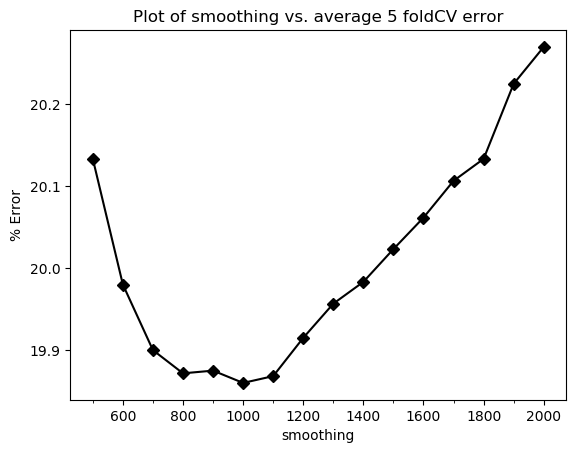

The best value of smoothing is 1000 with an error of 19.86%

smoothing = 1000 will be used to model the entire training set and prediction on testing set:


In [46]:
sm_plot = Utility.CV_plot(kfold_nb, smoothings_nb, 'smoothing')

In [26]:
util = Utility()
best_s = smoothings_nb[np.argmin(kfold_nb)]
nb = NaiveBayes(train=util.train, train_lb=util.train_label, test=util.test, test_lb=util.test_label, smoothing=best_s)
nb.predict()
conf_matix = util.confusionMatrix(util.test_label, nb.pred)

Testing Confusion Matrix: Actual vs. Prediction


,0,1,2,3,4,5,6,7,8,9
0,902,0,0,4,1,11,20,1,37,4
1,0,1096,1,4,0,0,6,0,28,0
2,15,36,778,31,9,5,59,14,79,6
3,6,34,26,814,0,18,15,11,44,42
4,4,6,5,0,640,4,22,0,19,282
5,19,28,7,94,23,574,24,11,64,48
6,12,22,12,1,8,24,865,0,13,1
7,1,38,8,4,20,0,1,837,25,94
8,8,67,8,36,11,17,12,4,742,69
9,6,16,3,9,38,1,0,15,20,901


% error per digit


,digit,error per digit in %
0,0,7.96
1,1,3.44
2,2,24.61
3,3,19.41
4,4,34.83
5,5,35.65
6,6,9.71
7,7,18.58
8,8,23.82
9,9,10.70



The overall testing error is 18.51%


From the information above the overall error is 18.51% (which is about 81.49% accuracy). The digits 0 and 1 tend to have minimal error rate compare to the other digits, this can be attributed to the fact that the digits 0 and 1 have low variabilities. Generally, people tend to write digits 0 and 1 in the right way.

Digits 4 & 5 have the high error rates, visualizing some of them show that they have high variations. Digit 4 is mostly misclassified has 9, some people tend to write 4 in a way that it looks like 9. Also, digit 2 is mostly misclassified as 8.

Digit 9 is mostly misclassified as either 4 or 8, likewise, digits 4 and 8 are also occasionally misclassified as 9.

Generally, Naive Bayes did poorly on the MNIST dataset, this could be attributed to the independent assumption which is likely not to be correct. Query time is faster compared to KNN, however, KNN provided better performance on the MNIST dataset. Naive Bayes doesn't perform well when there are repeated attributes or when attributes are not equally important, which are the case in the MNIST dataset.

#### Visualizing the 784 conditional probabilities per class (as 28 x 28 images) for a test sample with actual label 1 which is rightly classified:

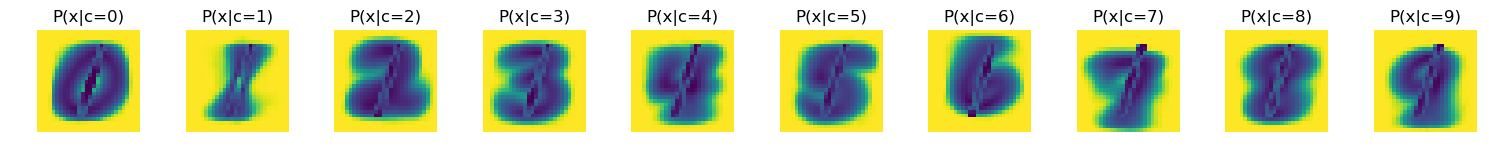

In [14]:
Utility.images_plot(nb.likelihood[2])

This is really fascinating, the classifier actually modeled the image that corresponds to the class, i.e P(x|c=0) modeled an image of 0, etc. While the actual label is presented on the modeled image. Thus, in the case above, the actual label really match the C=1.

#### Visualizing the 784 conditional probabilities per class (as 28 x 28 images) for a test sample with actual label 4 which is wrongly classified as 9:

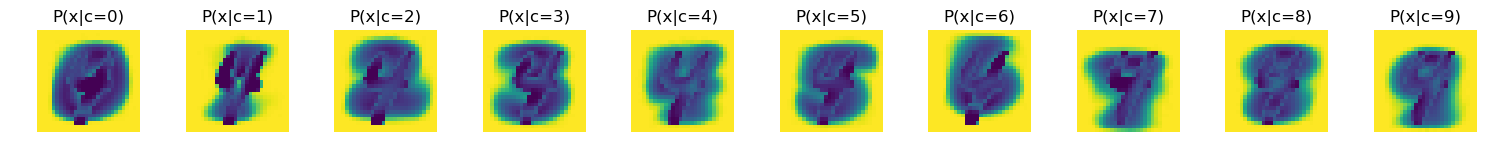

In [15]:
Utility.images_plot(nb.likelihood[9997])

In this instance, the actual label doesn't fit well on P(x|c=4), it seems more fitted on P(x|c=9), hence the classier prediction it as 9. On the confusion matrix, digit 4 is mostly classified as 9. Some people tend to write 4 in a way that it looks like 9.